<a href="https://colab.research.google.com/github/divyakathane/FDIP/blob/main/ASS_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

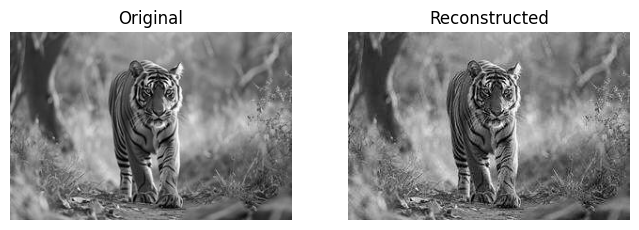

Compression Ratio: 4.39
PSNR (dB): 30.63


In [6]:
# Simple & correct: DCT (8x8) + Quantization + Huffman (no zigzag/RLE, keeps code short)
import cv2, math, heapq, numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

# ---------- Helpers ----------
def pad_to_8(img):
    h,w = img.shape
    nh = ((h + 7)//8)*8
    nw = ((w + 7)//8)*8
    pad_h = nh - h
    pad_w = nw - w
    return cv2.copyMakeBorder(img,0,pad_h,0,pad_w, cv2.BORDER_REPLICATE), h, w

def dct2(b): return dct(dct(b.T, norm='ortho').T, norm='ortho')
def idct2(b): return idct(idct(b.T, norm='ortho').T, norm='ortho')

# Standard JPEG-like base quant matrix (Q50)
Q50 = np.array([
 [16,11,10,16,24,40,51,61],
 [12,12,14,19,26,58,60,55],
 [14,13,16,24,40,57,69,56],
 [14,17,22,29,51,87,80,62],
 [18,22,37,56,68,109,103,77],
 [24,35,55,64,81,104,113,92],
 [49,64,78,87,103,121,120,101],
 [72,92,95,98,112,100,103,99]
], dtype=np.float32)

def scale_Q(Q50, quality):
    q = max(1, min(100, quality))
    if q < 50:
        scale = 5000.0 / q
    else:
        scale = 200.0 - 2.0 * q
    Q = np.floor((Q50 * scale + 50.0) / 100.0)
    Q[Q == 0] = 1
    return Q

# ---------- Huffman (build tree, codes, encode/decode) ----------
class HNode:
    def __init__(self, symbol=None, freq=0, left=None, right=None):
        self.symbol = symbol
        self.freq = freq
        self.left = left
        self.right = right

def build_huffman(freqdict):
    heap = []
    cnt = 0
    for s,f in freqdict.items():
        heapq.heappush(heap, (f, cnt, HNode(symbol=s, freq=f)))
        cnt += 1
    if len(heap) == 0:
        return None, {}
    if len(heap) == 1:
        _,_,node = heapq.heappop(heap)
        return node, {node.symbol: '0'}
    while len(heap) > 1:
        f1,c1,n1 = heapq.heappop(heap)
        f2,c2,n2 = heapq.heappop(heap)
        merged = HNode(symbol=None, freq=f1+f2, left=n1, right=n2)
        heapq.heappush(heap, (merged.freq, cnt, merged)); cnt += 1
    root = heapq.heappop(heap)[2]
    codes = {}
    def traverse(node, prefix):
        if node.symbol is not None:
            codes[node.symbol] = prefix if prefix!="" else "0"
            return
        traverse(node.left, prefix + "0")
        traverse(node.right, prefix + "1")
    traverse(root, "")
    return root, codes

def huffman_encode(symbols, codes):
    return ''.join(codes[s] for s in symbols)

def huffman_decode(bitstr, root, expected_count):
    if root is None:
        return []
    # special single-symbol tree
    if root.symbol is not None:
        return [root.symbol] * expected_count
    decoded = []
    node = root
    for b in bitstr:
        node = node.left if b == '0' else node.right
        if node.symbol is not None:
            decoded.append(node.symbol)
            node = root
            if len(decoded) == expected_count:
                break
    # pad/trim to expected_count (safety)
    if len(decoded) < expected_count:
        decoded += [0] * (expected_count - len(decoded))
    else:
        decoded = decoded[:expected_count]
    return decoded

# ---------- Main simple pipeline ----------
def compress_dct_huffman(img_gray, quality=50):
    padded, orig_h, orig_w = pad_to_8(img_gray)
    nh, nw = padded.shape
    Q = scale_Q(Q50, quality)
    symbols = []
    # collect flattened quantized blocks (row-major)
    for i in range(0, nh, 8):
        for j in range(0, nw, 8):
            block = padded[i:i+8, j:j+8].astype(np.float32) - 128.0
            d = dct2(block)
            q = np.round(d / Q).astype(int)
            symbols.extend(q.flatten().tolist())
    # Huffman
    freq = {}
    for s in symbols: freq[s] = freq.get(s,0) + 1
    root, codes = build_huffman(freq)
    bitstream = huffman_encode(symbols, codes)
    return {
        'bitstream': bitstream,
        'root': root,
        'codes': codes,
        'padded_shape': (nh,nw),
        'orig_shape': (orig_h, orig_w),
        'Q': Q,
        'num_symbols': len(symbols)
    }

def decompress_dct_huffman(pack):
    bitstream = pack['bitstream']
    root = pack['root']
    nh, nw = pack['padded_shape']
    Q = pack['Q']
    total = pack['num_symbols']
    decoded = huffman_decode(bitstream, root, total)
    # reconstruct blocks
    arr = np.array(decoded, dtype=np.float32).reshape(-1, 64)
    rec = np.zeros((nh, nw), dtype=np.float32)
    idx = 0
    for i in range(0, nh, 8):
        for j in range(0, nw, 8):
            qblk = arr[idx].reshape(8,8)
            deq = (qblk * Q).astype(np.float32)
            idb = idct2(deq) + 128.0
            rec[i:i+8, j:j+8] = idb
            idx += 1
    return np.clip(rec, 0, 255).astype(np.uint8)

def psnr(a,b):
    mse = np.mean((a.astype(np.float64)-b.astype(np.float64))**2)
    if mse == 0: return float('inf')
    return 10 * math.log10(255*255 / mse)

# ---------- Run example ----------
img = cv2.imread('/content/fdip pic.jpg', cv2.IMREAD_GRAYSCALE)  # change path if needed
if img is None:
    raise SystemExit("Put an image named 'image.jpg' in the working folder or change the path.")

pack = compress_dct_huffman(img, quality=50)
recon = decompress_dct_huffman(pack)

# crop to original size (pad -> original dims)
orig_h, orig_w = pack['orig_shape']
recon_cropped = recon[:orig_h, :orig_w]

# display + metrics
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(recon_cropped, cmap='gray'); plt.title('Reconstructed'); plt.axis('off')
plt.show()

orig_bits = img.size * 8
comp_bits = len(pack['bitstream']) if pack['bitstream'] else 1
print("Compression Ratio:", round(orig_bits/comp_bits, 2))
print("PSNR (dB):", round(psnr(img, recon_cropped), 2))
